In [13]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle

from plotter import *

In [14]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

In [15]:
deta_cut = 3.5

deta_cut_mucr = 0
mjj_cut_mucr = 0

In [16]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [17]:
repickle=True

# Check if pickle exists, and don't re-create it if it does
picklename = 'pickles/'+str(year)+'_templates.pkl'
if os.path.isfile(picklename):
    repickle=False

In [18]:
# Load all files - this takes a while
if repickle:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
    
        filename = '/myeosdir/vbf-category/outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vbf'].scale(scale_lumi, 'dataset')
    templates = outsum['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap)

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

In [23]:
# Read the histogram from the pickle file
templates = pickle.load(open(picklename,'rb'))
templates_vbf = templates.integrate('region','signal').integrate('deta',int_range=slice(deta_cut,7))
templates_vbf_mucr = templates.integrate('region','muoncontrol').integrate('deta',int_range=slice(deta_cut_mucr,7)).integrate('mjj',int_range=slice(mjj_cut_mucr,4000))

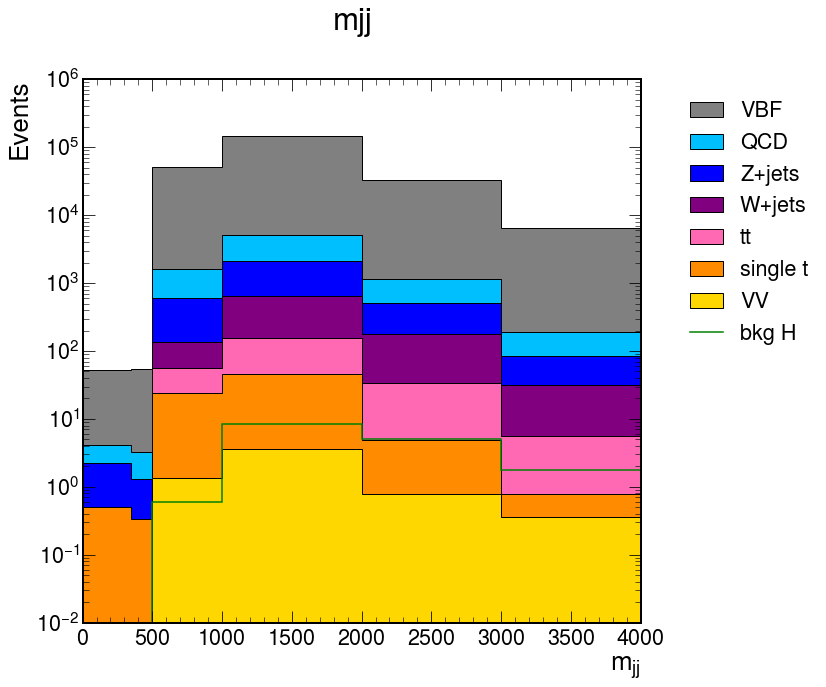

In [20]:
h = templates_vbf.integrate('systematic','nominal').sum('pt1','ddb1','msd1')
plot_mconly_vbf(h, 'mjj', 'mjj')

In [21]:
mjjbins = [500,1000, 2000, 4000]
os.system('rm '+year+'/3mjj-signalregion.root')
fout = uproot3.create(year+'/3mjj-signalregion.root')

for i,b in enumerate(mjjbins[:-1]):
    for p in pmap.keys(): 
        if p == "ttH" and year == '2016':
            continue
        print(p)
        if "data" in p:
            s = "nominal"
            h = templates_vbf.integrate('systematic',s).sum('pt1').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
            fout["pass_mjj"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
            h = templates_vbf.integrate('systematic',s).sum('pt1').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
            fout["fail_mjj"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
        else:
            for s in systematics:
                h = templates_vbf.integrate('systematic',s).sum('pt1').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
                fout["pass_mjj"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
                h = templates_vbf.integrate('systematic',s).sum('pt1').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
                fout["fail_mjj"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)

fout.close()

ZH
WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata
ZH
WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata
ZH
WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata


In [24]:
os.system('rm '+year+'/muonCR.root')
fout = uproot3.create(year+'/muonCR.root')
for p in pmap.keys():  
    if p == 'ttH' and year == '2016':
        continue
    print(p)
    if "data" in p:
        s = "nominal"
        h = templates_vbf_mucr.integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
        fout["pass_"+p+"_"+s] = hist.export1d(h)
        h = templates_vbf_mucr.integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
        fout["fail_"+p+"_"+s] = hist.export1d(h)
    else:
        for s in systematics:
            h = templates_vbf_mucr.integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
            fout["pass_"+p+"_"+s] = hist.export1d(h)
            h = templates_vbf_mucr.integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
            fout["fail_"+p+"_"+s] = hist.export1d(h)

ZH
WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata
